# Basic Overview
The idea here is to build an optimum model using xgboost method.

Comments/criticisms/appreciations are greatly accepted and appreciated.

Source of data : https://www.kaggle.com/c/titanic/data

In [57]:
import pandas as pd
import numpy as np

In [58]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [59]:
# Ha
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [60]:
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

Since XGBoost uses only numeric predictors, and we do not want to increase dimensionality, we will go with numeric encoding for sex and plcass variables for now.

In [61]:
train_data.loc[(train_data['Sex'] == 'male'), 'Sex'] = 1
train_data.loc[(train_data['Sex'] == 'female'), 'Sex'] = 0

test_data.loc[(test_data['Sex'] == 'male'), 'Sex'] = 1
test_data.loc[(test_data['Sex'] == 'female'), 'Sex'] = 0


In [ ]:
# Since we see that lots of entries are having Cabin fields set to null, we add that information and see how much 
# it will help us.
train_data['IsCabinNull'] = 

In [62]:
# Add a column called Predictions in training data, which will become handy while doing
# cross validation.
train_data['Predictions'] = -1

In [63]:
from sklearn.preprocessing import Imputer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [64]:
def get_train_test_data(train_data,
                        X_columns=['Sex', 'Pclass', 'Age'], 
                        Y_columns=['Survived']):
    # Simple training and testing
    X = train_data[X_columns]
    Y = train_data[Y_columns]

    X_one_hot = pd.get_dummies(X)

    # Do imputation on relevant columns.
    X_train, X_test, Y_train, Y_test = train_test_split(X_one_hot, Y, random_state=0)

    return (X_train, X_test, Y_train, Y_test, X_one_hot, Y)


In [65]:
def create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test, n_estimators=100, 
                                            learning_rate=0.1):
    # Rewrite everything as a pipeline
    my_pipeline = make_pipeline(Imputer(), 
                                XGBClassifier(seed=1, n_estimators=n_estimators, learning_rate=learning_rate))
    my_pipeline.fit(X_train, Y_train.values.ravel())
    predictions = my_pipeline.predict(X_test)
    out_of_sample_score = 1.0 - mean_absolute_error(predictions, Y_test)
    return (my_pipeline, out_of_sample_score, predictions)

In [66]:
def cross_validate(my_pipeline, X_one_hot, Y):
    cross_val_scores = cross_val_score(my_pipeline, X_one_hot, Y, scoring='neg_mean_absolute_error', cv=5)
    return 1.0  + cross_val_scores.mean()

In [67]:
def train_test_cross_validate(train_data, 
                              X_columns=['Sex', 'Pclass', 'Age'], 
                              Y_columns=['Survived'],
                              n_estimators=100,
                              learning_rate=0.1):
    (X_train, X_test, Y_train, Y_test, X_one_hot, Y) = get_train_test_data(train_data, X_columns, Y_columns)
    my_pipeline, out_of_sample_score, predictions_test = \
        create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test, n_estimators, learning_rate)

    print("Number of entries in training set is {0}".format(len(X_train)))
    predictions_train = my_pipeline.predict(X_train)
    num_correct_predictions_train = int((1.0 - mean_absolute_error(predictions_train, Y_train)) * len(Y_train))


    print("Number of correct predictions in training set is {0}".format(num_correct_predictions_train))    
    print("Number of entries in test set is {0}".format(len(X_test)))    
    print("Number of correct predictions in test set is {0}".format(int(out_of_sample_score * len(X_test))))

    cross_validation_score = cross_validate(make_pipeline(Imputer(), 
                                                          XGBClassifier(seed=1,
                                                                        n_estimators=n_estimators, 
                                                                        learning_rate=learning_rate)), 
                                            X_one_hot, Y.values.ravel())
    return (my_pipeline, out_of_sample_score, cross_validation_score)

In [68]:
# Make sure that unnecessary deprecation warnings are avoided.
# Thanks to https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


### Correlation between predictors. 

In [69]:
train_data[['Survived', 'Pclass', 'Age', 'Sex']].corr()

,Survived,Pclass,Age,Sex
Survived,1.000000,-0.338481,-0.077221,-0.543351
Pclass,-0.338481,1.000000,-0.369226,0.131900
Age,-0.077221,-0.369226,1.000000,0.093254
Sex,-0.543351,0.131900,0.093254,1.000000


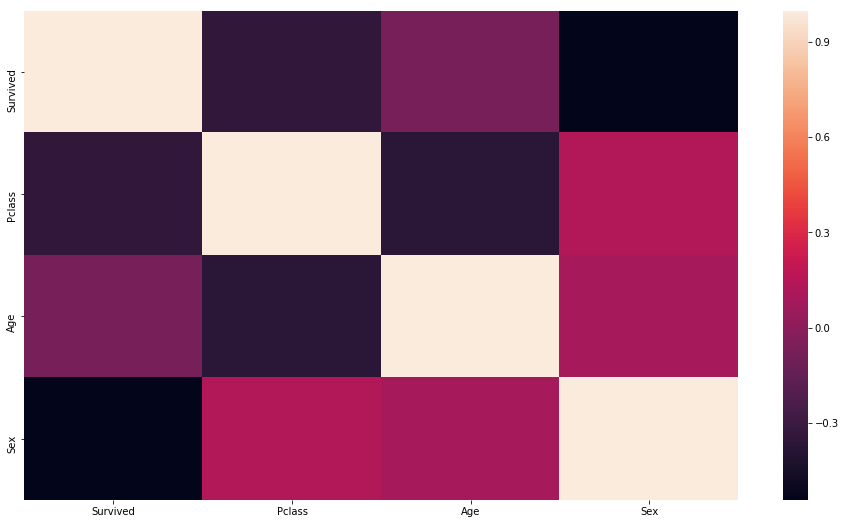

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.heatmap(train_data[['Survived', 'Pclass', 'Age', 'Sex']].corr(), ax=ax)

The correlation level looks acceptable here.

In [71]:
# Get the XGBclassifier directly as it is far easier to visualize this than the
# pipeline object.
def get_sklearn_xgbclassifier(train_data, X_columns=['Sex'], Y_columns=['Survived']):
    my_model = XGBClassifier(seed=1)
    X_train = train_data[X_columns]
    Y_train = train_data[Y_columns]
    my_model.fit(X_train, Y_train.values.ravel())    
    return my_model

In [72]:
def get_gridsearch_crossval_output(train_data, 
                                   X_columns = ['Sex', 'Pclass'], 
                                   Y_columns = ['Survived'],
                                   n_estimators_list = [10, 50, 70, 100, 120, 150, 200],
                                   learning_rates_list = [0.01, 0.02, 0.05, 0.07, 0.1],
                                   early_stopping_round = 10,
                                   num_cross_val_sets = 5
                                  ):
    (X_train, X_test, Y_train, Y_test, X_one_hot, Y) = get_train_test_data(train_data, X_columns, Y_columns)
    col_names = ['f' + str(i) for i in range(len(X_train.columns))]
    X_train.columns = col_names
    X_test.columns = col_names
    my_pipeline = Pipeline([('imputer', Imputer()), ('xgcl', XGBClassifier())])
    param_grid = {
        'xgcl__n_estimators' : n_estimators_list,
        'xgcl__learning_rate' : learning_rates_list
    }
    fit_params = {'xgcl__eval_set' : [(X_test, Y_test.values.ravel())],
                  'xgcl__early_stopping_rounds' : early_stopping_round,
                  'xgcl__verbose': False}

    searchCV = GridSearchCV(my_pipeline, cv=num_cross_val_sets, param_grid=param_grid, fit_params=fit_params)
    searchCV.fit(X_train, Y_train.values.ravel())
    return searchCV

In [73]:
def get_model_metrics_and_display(train_data, X_columns=['Sex'], Y_columns=['Survived']):
    (my_pipeline, out_of_sample_score, cross_validation_score) = \
        train_test_cross_validate(train_data,
                                  X_columns, 
                                  Y_columns)

    print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))
    my_model = get_sklearn_xgbclassifier(train_data, X_columns, Y_columns)
    return my_model
    

### Model 1: Sex as the only predictor

#### Basic training/cross validation

In [74]:
X_columns = ['Sex']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 527
Number of entries in test set is 223
Number of correct predictions in test set is 174
Out of sample score is 0.7802690582959642
Cross val score is 0.7867150249291879


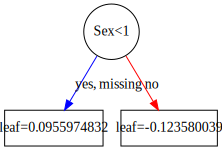

In [75]:
my_model = get_model_metrics_and_display(train_data,X_columns=['Sex'])
xgb.to_graphviz(my_model)


### Model 2: Sex and Pclass as predictors.

#### Basic training/cross validation

In [76]:
X_columns = ['Sex', 'Pclass']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 527
Number of entries in test set is 223
Number of correct predictions in test set is 174
Out of sample score is 0.7802690582959642
Cross val score is 0.7733072037001376


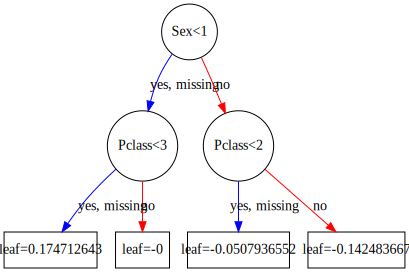

In [77]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


It looks like here, we are not taking into account pclass here. Hence, let us see if we can finetune the model to take into account plcass as well.

### Model 3: Sex, Pclass  and Age as predictors.

#### Basic training/cross validation

In [78]:
X_columns = ['Sex', 'Pclass', 'Age']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 562
Number of entries in test set is 223
Number of correct predictions in test set is 184
Out of sample score is 0.8251121076233183
Cross val score is 0.8025148353403998


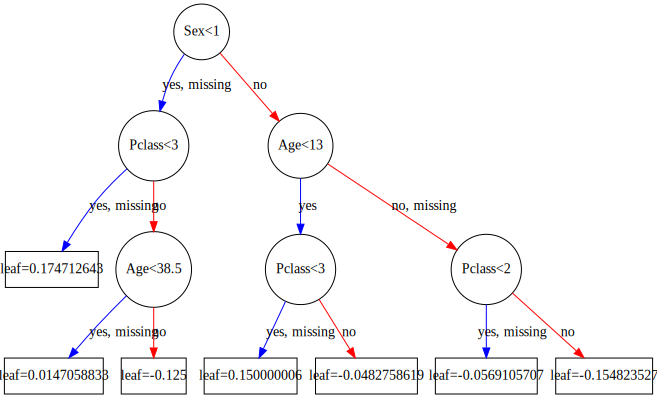

In [79]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


### Model 4: Sex, Pclass,Age,Fare as predictors.

In [80]:
X_columns = ['Sex', 'Pclass', 'Age', 'Fare']
Y_columns = ['Survived']

Number of entries in training set is 668
Number of correct predictions in training set is 576
Number of entries in test set is 223
Number of correct predictions in test set is 186
Out of sample score is 0.8340807174887892
Cross val score is 0.8305672733436958


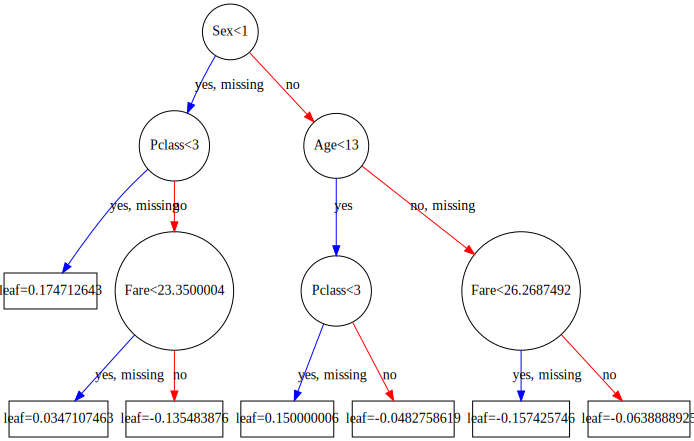

In [81]:
my_model = get_model_metrics_and_display(train_data,X_columns=X_columns)
xgb.to_graphviz(my_model)


Comments : Since ,we see significant improvement in our cross validation score, we proceed with more fine tuning on this model.

#### Fine tuning using cross validation

In [82]:
X_train = train_data[X_columns]
Y_train = train_data[Y_columns]
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
params = {"Objective" : 'gbtree',
          "eval_metric" : 'error',
          'learning_rate' : 0.01
         }
cv = xgb.cv(dtrain=dtrain, params=params, num_boost_round=500, nfold=5, seed=0, early_stopping_rounds=10)

In [83]:
cv.tail(10)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.191946,0.027087,0.131874,0.002643
1,0.189699,0.024371,0.129630,0.003032


#### Fine tuning using grid searchCV

In [84]:
searchCV = get_gridsearch_crossval_output(train_data, X_columns=X_columns,
                                          Y_columns = ['Survived'],
                                          n_estimators_list = [1, 2, 3, 4 , 5, 6 ,7 ,8 , 10, 15, 18, 20, 50, 70, 100, 120, 150, 200])
searchCV.best_params_


{'xgcl__learning_rate': 0.01, 'xgcl__n_estimators': 1}

#### Creating a file with predictions on out of sample data

In [88]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
X_train = train_data[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data[Y_columns]
X_test = test_data[X_columns]
X_test_one_hot = pd.get_dummies(X_test)

# Create a dummy test data s
Y_test = np.ones(len(test_data[X_columns])) * -1
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test,
                                            1,
                                            0.01)
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_sex_pclass_age_fare.csv', index=False)